In [1]:
import numpy as np
import torch

In [2]:
from models import MPS, ComplexTensor

In [3]:
L=2
local_dim=2
bond_dim=2

In [4]:
psi = MPS(L=L, local_dim=local_dim, bond_dim=bond_dim)

In [5]:
fname_settings="datasets/settings_prod_state_spinup_L=%d.npy" %L
fname_samples="datasets/samples_prod_state_spinup_L=%d.npy"%L
# fname_settings = "settings_ghz_plus_all_discrete_bases_angles_L=%d.npy"%L
# fname_samples = "samples_ghz_plus_all_discrete_bases_angles_L=%d.npy"%L
samples = np.load(fname_samples)
samples_tr = torch.tensor((1-samples)/2).to(torch.long)
settings = np.load(fname_settings)

In [6]:
theta = torch.tensor(settings[...,0],dtype=torch.float32)
phi = torch.tensor(settings[...,1],dtype=torch.float32)

In [7]:
from qtools import pauli_exp

In [8]:
U = pauli_exp(theta, phi)
rotations_real = U.real
rotations_imag = U.imag

In [9]:
from torch.utils.data import TensorDataset, DataLoader

In [10]:
from models import MeasurementDataset, ComplexTensor

In [11]:
ds = MeasurementDataset(samples=samples_tr,rotations=U)

In [12]:
batch_size = 256
lr = .001

In [13]:
dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

In [14]:
losses = []

In [15]:
eps = 5

In [16]:
nstep=1

In [17]:
max_sv = None
cutoff=1e-6

In [19]:
for ep in range(eps):
    for step, inputs in enumerate(dl):
        
        spinconfig = inputs['samples']
        rot = inputs['rotations']
        rotations = ComplexTensor(rot['real'], rot['imag'])
        with torch.no_grad():
            for i in range(L-1):
                for __ in range(nstep):
                    psi.do_sgd_step(i, spinconfig, rotation=rotations,
                                       cutoff=cutoff,normalize='left',max_sv_to_keep=max_sv,
                                       learning_rate=lr) 
            for i in range(L-2, -1,-1):
                for __ in range(nstep):
                    psi.do_sgd_step(i, spinconfig, rotation=rotations,
                                       cutoff=cutoff,normalize='left',max_sv_to_keep=max_sv,
                                       learning_rate=lr) 
                losses.append(psi.nll_loss(spinconfig,rotation=rotations))
    print("finished epoch %d" % ep)

        

finished epoch 0
finished epoch 1
finished epoch 2
finished epoch 3
finished epoch 4


In [20]:
import matplotlib.pyplot as plt

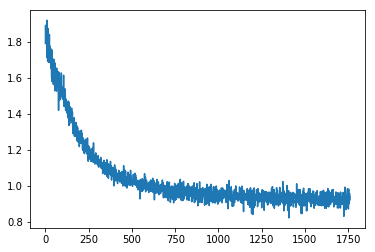

In [21]:
%matplotlib inline
plt.plot(losses)

In [22]:
print(psi.shape)

[(1, 2), (2, 1)]


In [23]:
from tools import generate_binary_space

In [24]:
basis = torch.tensor(generate_binary_space(L),dtype=torch.long)

In [25]:
with torch.no_grad():
    for i in range(len(basis)):
        print("{0} has probability {1:.4f}".format(basis[i], psi.prob_normalized(basis[i]).item()))

tensor([1, 1]) has probability 0.0000
tensor([1, 0]) has probability 0.0035
tensor([0, 1]) has probability 0.0055
tensor([0, 0]) has probability 0.9910
